# Comparison Between Adaboost and SVM

This notebook compares the accuracy produced by Adaboost and SVM when run on the banana and splice datasets.

The Adaboost algorithm itself does not use any module other than numpy. We only used sklearn for the train_test_split. **Again, no sklearn in the actual adaboost algorithm itself**.

SVM was implemented using the sklearn package. Moreover, GridSearchCV was used to fine-tune the parameters.

We only used LabelEncoder for SMOTE (on the splice dataset since the instructions for training and test points did not match with the instructions on the pdf) and is no way used to build our algorithm. With that said, imblearn was also used only in SMOTE



In [ ]:
import imblearn
import numpy as np
import time
from collections import Counter
from functools import partial
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

### Perceptron Classifier Construction

The following cells consist of the following:
- Generate synthetic data as per instructions in the pdf
- Wrote function named **classify** that implements the Pocket Algorithm
- Varied the *maxitercnt* and displayed how the perceptron performs by plotting the sum of square errors per iteration
- Wrote the function **predict** which we will use to give us the predicted values for any input given

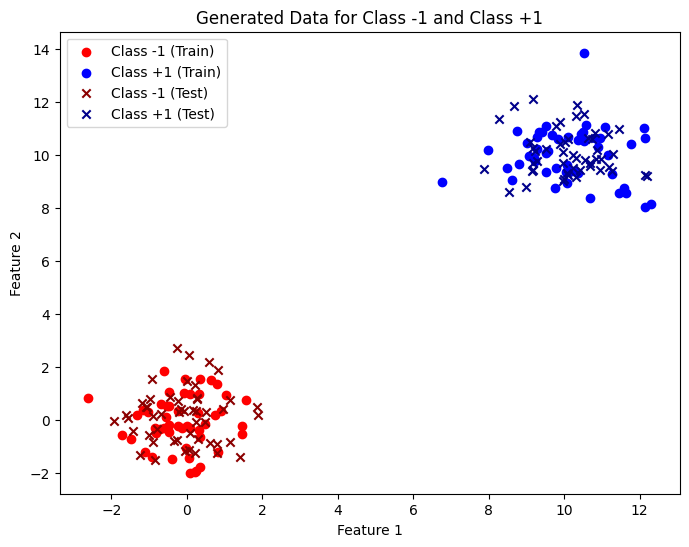

In [191]:
#-------------------------------------
# Generating our synthetic data
#-------------------------------------

# Parameters for the normal distributions
mu1 = [0, 0]  # Mean for class -1
mu2 = [10, 10]  # Mean for class +1
sigma = np.eye(2)  # Identity matrix as the covariance matrix (σ = I)

np.random.seed(42)

# Generate 100 data points for each class
class_minus_1_train = np.random.multivariate_normal(mu1, sigma, 50)  # 50 points for training class -1
class_minus_1_test = np.random.multivariate_normal(mu1, sigma, 50)   # 50 points for testing class -1

class_plus_1_train = np.random.multivariate_normal(mu2, sigma, 50)   # 50 points for training class +1
class_plus_1_test = np.random.multivariate_normal(mu2, sigma, 50)    # 50 points for testing class +1

# Combine the training and test sets
X_synth_train = np.vstack((class_minus_1_train, class_plus_1_train))  # Training data
X_synth_test = np.vstack((class_minus_1_test, class_plus_1_test))    # Test data

# Create the corresponding labels for training and test sets
y_synth_train = np.concatenate((np.ones(50) * -1, np.ones(50)))  # Labels: -1 for class -1, +1 for class +1
y_synth_test = np.concatenate((np.ones(50) * -1, np.ones(50)))   # Labels for test data

# Plotting the data distribution
plt.figure(figsize=(8, 6))
plt.scatter(class_minus_1_train[:, 0], class_minus_1_train[:, 1], color='red', label='Class -1 (Train)')
plt.scatter(class_plus_1_train[:, 0], class_plus_1_train[:, 1], color='blue', label='Class +1 (Train)')
plt.scatter(class_minus_1_test[:, 0], class_minus_1_test[:, 1], color='darkred', label='Class -1 (Test)', marker='x')
plt.scatter(class_plus_1_test[:, 0], class_plus_1_test[:, 1], color='darkblue', label='Class +1 (Test)', marker='x')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Generated Data for Class -1 and Class +1')
plt.show()


In [192]:
#--------------------------------------------------------------
# Creation of classify and predict functions for our perceptron
#--------------------------------------------------------------

def classify(X, y, maxitercnt=10000):
    """
    Implements the pocket algorithm and is intended to be
    the weak learner for our boosting algorithm

    Args:
        X (np.ndarray): The training data set
        y (np.ndarray): The training label
        maxitercnt (int): Maximum iterations for our pocket
            algorithm

    Returns
        np.ndarray: Returns the trained weights of the perceptron
    """
    rows, cols = X.shape

    # Initialize nv, nw, v, and w
    nv = nw = 0
    v = w = np.zeros(cols + 1) 
    itercnt = 0
    ones_column = np.ones((X.shape[0], 1))
    new_X = np.hstack((ones_column, X))
    np.random.seed(42)
    while itercnt <= maxitercnt:
        # randomly choose an input pattern xj w/ label
        random_index = np.random.choice(rows)
        xj, yj = new_X[random_index], y[random_index]

        # compute the neuron's output
        yhat = 1 if np.dot(v, xj) >= 0 else -1

        # updating nv and w for the next iteration
        if yhat * yj > 0:
            nv += 1
        else:
            if nv > nw:
                w = v
                nw = nv
            
            v += yj * xj
            nv = 0
        
        itercnt += 1

    return w


def predict(X, weights):
    """
    Given the weights and an array with the appropriate
    dimensions, return the class predictions

    Args:
        X (np.ndarray): The set we want to predict the labels of
        weights (np.ndarray): Weights to be used for the prediction

    Returns:
        np.ndarray: An array containing 1s, 0s, and -1s
    """
    arr = np.dot(X, weights[1:]) + weights[0]
    return np.sign(arr)


Here we just saw the improvements to our pocket algorithm when we kept increasing the iterations.

We stopped training with our synthetic dataset once the sum of square errors stayed 0 for the latest 50 points

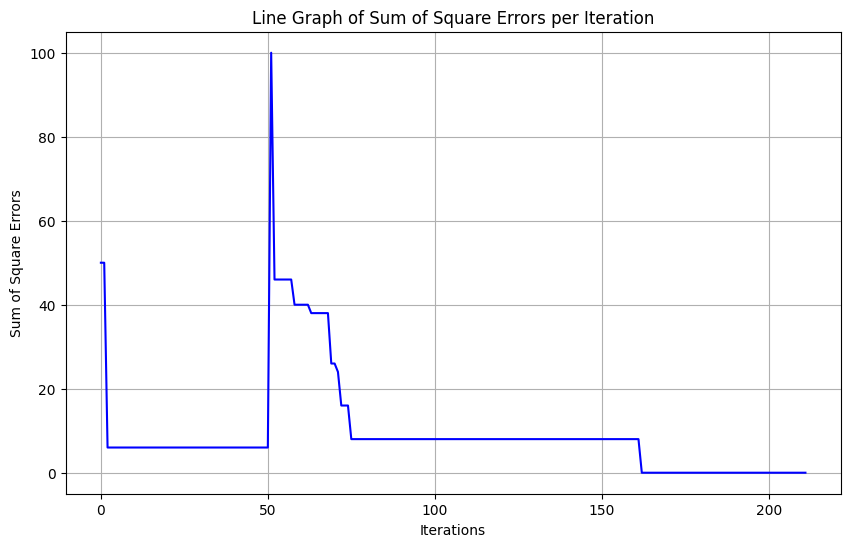

In [193]:
sses = []
for i in range(10000):
    w = classify(X_synth_train, y_synth_train, i)
    p = predict(X_synth_test, w)
    e = y_synth_test - p
    sse = 0.5 * np.dot(e, e)
    sses.append(sse)

    last_items = sses[-50:]
    if np.all(last_items == np.float64(0.0)):
        break


plt.figure(figsize=(10, 6))
plt.plot(range(len(sses)), sses, label="Feature1", color="blue", linestyle="-")
plt.title("Line Graph of Sum of Square Errors per Iteration")
plt.xlabel("Iterations")
plt.ylabel("Sum of Square Errors")
# plt.legend()
plt.grid(True)
plt.show()

### Adaboost Construction and Evaluation

Here we define 5 functions that we'll be using for the project
- adabtrain
- adabpredict
- accuracy
- evaluate_boosted_perceptron
- plot_graphs


**adabtrain** is what we'll be using to train our adaboost ensemble

**adabpredict**  just returns the prediction for a given set using the alphas and hypotheses we got after running adabtrain 

**accuracy** just to compute accuracy

**evaluate_boosted_perceptron** allows us to extract points (training and test accuracy + train/test speed) for plotting by running multiple values of K. Works in conjunction with adabtrain to continue training from the last number of learners we trained.

**plot_graphs** Helper function for plotting graphs



In [ ]:
def adabtrain(
    X_train, 
    y_train, 
    k=100, 
    weights=None, 
    alphas=None, 
    hypotheses=None
):
    """
    Implementation of the adaboost pseudocode found in the pdf.
    Uses the pocket algorithm as the basic learner. We have a
    mechanism to continue off where we trained for the last K
    learners. E.g. if last run we trained with K = 10 learners,
    and we want this run to go for K = 30 learners, then we'll
    start training from K = 10 and not K = 0. The params that
    make this possible are the weights, alphas, and hypotheses

    Args:
        X_train (np.ndarray): The training set to be used
        y_train (np.ndarray): The labels used in training
        k (int): The number of learners for our ensemble
        weights (np.ndarray): The sample weights of the ensemble.
            Input here is usually previous run's weight
        alphas (np.ndarray): Commonly the previous run's alphas
        hypotheses (np.ndarray): Commonly the previous run's hypotheses

    Returns:
        tuple: (
            alphas (np.ndarray): The sample weights of the
                ensemble
            hypotheses (np.ndarray): The function that would
                determine the prediction of a singular weak
                learner 
            weights (np.ndarray): The sample weights for the
                ensemble
        )
    """
    rows, _ = X_train.shape
    if weights is None:
        weights = np.full(rows, 1/rows)
    
    # These 2 will just convert to list if type is np.ndarray
    if type(alphas) is np.ndarray:
        alphas = list(alphas)
    elif alphas is None:
        alphas = []

    if type(hypotheses) is np.ndarray:
        hypotheses = list(hypotheses)
    elif hypotheses is None:
        hypotheses = []

    for t in range(len(alphas), k + 1):
        print(f'Currently at iteration: {t}')
        if t != 0:
            np.random.seed(t)
            resampled_indices = np.random.choice(
                np.arange(rows), size=rows, replace=True, p=weights)
            X_resampled = X_train[resampled_indices]
            y_resampled = y_train[resampled_indices]
        else:
            X_resampled, y_resampled = X_train, y_train

        w = classify(X_resampled, y_resampled)
        hypothesis = partial(predict, weights=w)
        hypotheses.append(hypothesis)
        prediction = hypothesis(X_train)

        # compute training error
        delta = (prediction != y_train).astype(int)
        epsilon = np.dot(weights, delta)

        # compute coefficient
        alpha = 0.5 * np.log((1 - epsilon) / epsilon)
        alphas.append(alpha)

        # compute the new weights
        single_wt_upd = weights * np.exp(-alpha * y_train * prediction)
        z = np.sum(single_wt_upd)
        weights = single_wt_upd / z

    alphas = np.array(alphas)
    hypotheses = np.array(hypotheses)
    return alphas, hypotheses, weights


def adabpredict(X_test, alphas, hypotheses):
    """
    Use the equation for the ensemble classifier as specified in the pdf
    to classify the test set

    Args:
        X_test (np.ndarray): Test set or any set to be predicted
        alphas (np.ndarray): Coefficients which will act as kind of a weight
            when doing the classification
        hypotheses (np.ndarray): Basically just tells us if the point is on
            the right side of the hyperplane. If it is then +1. Else, -1

    Returns:
        np.ndarray: The predicted labels for the test set
    """
    weak_preds = np.array([h(X_test) for h in hypotheses])
    final_preds = np.sign(np.dot(alphas, weak_preds))
    return final_preds


def accuracy(y_pred, y_test):
    """
    Returns the accuracy given the predicted value and the actual labels

    Args:
        y_pred (np.ndarray): The predicted value
        y_test (np.ndarray): The actual class labels

    Returns:
        float: The accuracy of the prediction of our classifier
    """
    return (y_pred == y_test).astype(int).sum() / len(y_test)


def evaluate_boosted_perceptron(
    X_train, 
    y_train, 
    X_test, 
    y_test,
    learners_to_eval=1000,
    learners_inc=10,
    start=10
):
    """
    Uses both adabtrain and adabpredict to train the boosted perceptron
    algorithm and measure the training and test accuracies for the ensemble
    classifier having K learners. K learners to gather metrics start from 10
    and increments by 10 up to 1000 learners.

    Args:
        X_train (np.ndarray): The training dataset
        y_train (np.ndarray): The training label
        X_test (np.ndarray): The test dataset
        y_test (np.ndarray): The test lable
        learners_to_eval (int): Up to how many learners we're gathering metrics
        learners_inc (int): increment of the learners
        start (int): where to start

    Returns:
        tuple: (
            test_accuracies (np.ndarray): The test accuracies per learner K
            train_accuracies (np.ndarray): The train accuracies per learner K
            test_speeds (np.ndarray): The time it took to test per learner K
            train_speeds (np.ndarray): The time it took to train per learner K
        )
    """
    test_accuracies = []
    train_accuracies = []
    test_speeds = []
    train_speeds = []
    alphas = None
    hypotheses = None
    weights = None
    for learners in range(start, learners_to_eval + 1, learners_inc):
        print('===================================')
        print(f'Accuracy for {learners} learners')
        
        start_train = time.time()
        alphas_l, hypotheses_l, weights_l = adabtrain(
            X_train, y_train, learners, weights, alphas, hypotheses)
        
        # _l means just recently came from learner. we reassign to main vars
        alphas = alphas_l
        hypotheses = hypotheses_l
        weights = weights_l
        
        end_train = time.time()
        train_speed = end_train - start_train
        train_speeds.append(train_speed)

        train_pred = adabpredict(X_train, alphas, hypotheses)

        start_test = time.time()
        test_pred = adabpredict(X_test, alphas, hypotheses)
        end_train = time.time()
        test_speed = end_train - start_test
        test_speeds.append(test_speed)

        train_accuracy = accuracy(train_pred, y_train)
        test_accuracy = accuracy(test_pred, y_test)
        
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f'Training accuracy: {train_accuracy}')
        print(f'Test accuracy: {test_accuracy}')
        print('===================================')
        print(' ')

    return test_accuracies, train_accuracies, test_speeds, train_speeds


def plot_graphs(title, xlabel='Learners', ylabel='Accuracy',**kwargs):
    """
    Reusable function that can plot the graphs of accuracies and other stuff

    Args:
        title (str): The title of the plot
        xlabel (str): Label of the x-axis
        ylabel (str): Label of the y-axis
        **kwargs: Expecting plot parameters for different arrays
    """
    plt.figure(figsize=(10, 6))
    for _, value in kwargs.items():
        label = value['label']
        data = value['data']
        color = value['color']
        linestyle = value['linestyle']
        x_ax = np.arange(10, 1010, 10)

        plt.plot(
            x_ax,
            data, 
            label=label, 
            color=color, 
            linestyle=linestyle
        )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    # plt.grid(True)
    plt.show()

### Plotting the banana dataset

The banana dataset is fairly straightforward. We load the banana_data.csv file and then we generate the training and test sets + labels. 

We also use train_test_split to get a train size of 400 and a test size of 4900.

We then plot the accuracies for training and test sets.

In [ ]:
#-----------------------------------------
# Here we load the banana dataset
# Total size = 5300
# Train size = 400
# Test size = 4900
#------------------------------------------

banana = np.loadtxt('banana_data.csv', delimiter=',')
X_banana, y_banana = banana[:, 1:], banana[:, 0]
X_banana_train, X_banana_test, y_banana_train, y_banana_test = train_test_split(
    X_banana, y_banana, train_size=400, test_size=4900)

banana_counter = Counter(y_banana)
banana_counter

Counter({np.float64(-1.0): 2924, np.float64(1.0): 2376})

In [ ]:
#----------------------------------------------------
# We use the evaluate_boosted_perceptron function to
# extract points we want to plot (accuracy and)
#----------------------------------------------------

(
    banana_test_accuracies, 
    banana_train_accuracies, 
    banana_test_speeds, 
    banana_train_speeds
) = evaluate_boosted_perceptron(
    X_banana_train, 
    y_banana_train, 
    X_banana_test, 
    y_banana_test, 
    learners_to_eval=1000
)

Accuracy for 10 learners
Currently at iteration: 0
Currently at iteration: 1
Currently at iteration: 2
Currently at iteration: 3
Currently at iteration: 4
Currently at iteration: 5
Currently at iteration: 6
Currently at iteration: 7
Currently at iteration: 8
Currently at iteration: 9
Currently at iteration: 10
Training accuracy: 0.68
Test accuracy: 0.686530612244898
 
Accuracy for 20 learners
Currently at iteration: 11
Currently at iteration: 12
Currently at iteration: 13
Currently at iteration: 14
Currently at iteration: 15
Currently at iteration: 16
Currently at iteration: 17
Currently at iteration: 18
Currently at iteration: 19
Currently at iteration: 20
Training accuracy: 0.7575
Test accuracy: 0.7359183673469388
 
Accuracy for 30 learners
Currently at iteration: 21
Currently at iteration: 22
Currently at iteration: 23
Currently at iteration: 24
Currently at iteration: 25
Currently at iteration: 26
Currently at iteration: 27
Currently at iteration: 28
Currently at iteration: 29
Curr

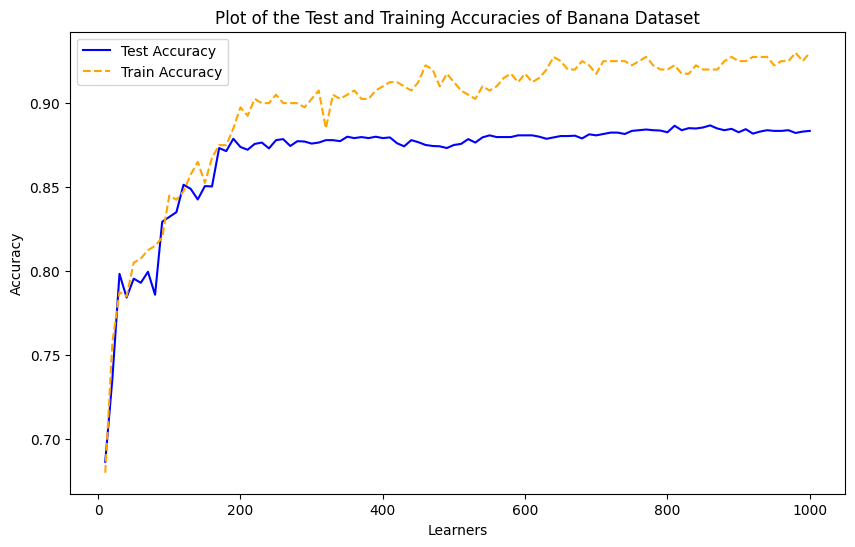

In [197]:
#-------------------------------------------
# Plot the accuracies for the banana dataset
#-------------------------------------------

plot_graphs(
    'Plot of the Test and Training Accuracies of Banana Dataset',
    testacc={ 'data': banana_test_accuracies, 'label': 'Test Accuracy', 'color': 'blue', 'linestyle': '-' },
    trainacc={ 'data': banana_train_accuracies, 'label': 'Train Accuracy', 'color': 'orange', 'linestyle': '--' }
)

Training time for banana dataset: 140.33493876457214 s
Test time for banana dataset: 0.0270845890045166


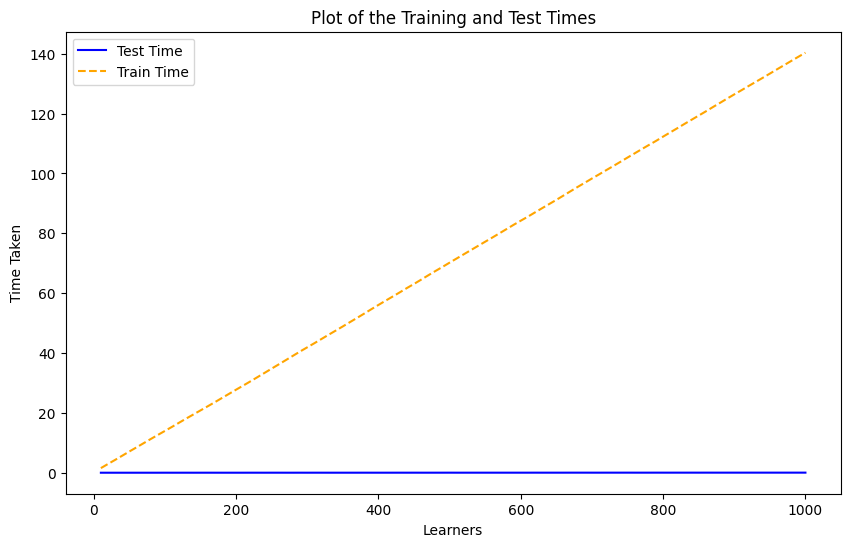

In [216]:

banana_cum_sum = np.cumsum(banana_train_speeds)
print(f'Training time for banana dataset: {banana_cum_sum[-1]} s')
print(f'Test time for banana dataset: {banana_test_speeds[-1]}')

plot_graphs(
    'Plot of the Training and Test Times',
    ylabel='Time Taken',
    testacc={ 'data': banana_test_speeds, 'label': 'Test Time', 'color': 'blue', 'linestyle': '-' },
    trainacc={ 'data': banana_cum_sum, 'label': 'Train Time', 'color': 'orange', 'linestyle': '--' }
)

### Plotting the splice dataset

Here it wasn't as straightforward. Instructions were to use 1000 points for training and 2175 points for the test set. However, the splice dataset only has 2991 rows. There is an option to have some data in our training set be also in the test set. However, multiple sources said that it's preferrable to have test and training sets be mutually exclusive. Therefore we just settled by using SMOTE to oversample some data just so we have enough to satisfy the instructions.

Then it's the usual with getting datapoints to plot the accuracy

In [ ]:
#-----------------------------------------------------
# Generate test and train sets for the splice dataset.
# Used smote to satisfy requirements
#-----------------------------------------------------

splice = np.loadtxt('splice_data.csv', delimiter=',')
X_splice, y_splice = splice[:, 1:], splice[:, 0]
y_splice_transformed = LabelEncoder().fit_transform(y_splice)
oversample = imblearn.over_sampling.SMOTE(random_state=42)
X_splice_smote, y_splice_smote = oversample.fit_resample(X_splice, y_splice)
X_splice_train, X_splice_test, y_splice_train, y_splice_test = train_test_split(
    X_splice_smote, y_splice_smote, train_size=1000, test_size=2175)

counter = Counter(y_splice_smote)
for k, v in counter.items():
    per = v / len(y_splice_smote) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=-1, n=1647 (50.000%)
Class=1, n=1647 (50.000%)


In [ ]:
#---------------------------------------------------
# We use the evaluate_boosted_perceptron function to
# extract points we want to plot (accuracy and speed) 
#---------------------------------------------------

(
    splice_test_accuracies, 
    splice_train_accuracies, 
    splice_test_speeds, 
    splice_train_speeds
) = evaluate_boosted_perceptron(
    X_splice_train, 
    y_splice_train, 
    X_splice_test, 
    y_splice_test, 
    learners_to_eval=1000
)

Accuracy for 10 learners
Currently at iteration: 0
Currently at iteration: 1
Currently at iteration: 2
Currently at iteration: 3
Currently at iteration: 4
Currently at iteration: 5
Currently at iteration: 6
Currently at iteration: 7
Currently at iteration: 8
Currently at iteration: 9
Currently at iteration: 10
Training accuracy: 0.847
Test accuracy: 0.8119540229885057
 
Accuracy for 20 learners
Currently at iteration: 11
Currently at iteration: 12
Currently at iteration: 13
Currently at iteration: 14
Currently at iteration: 15
Currently at iteration: 16
Currently at iteration: 17
Currently at iteration: 18
Currently at iteration: 19
Currently at iteration: 20
Training accuracy: 0.85
Test accuracy: 0.8073563218390805
 
Accuracy for 30 learners
Currently at iteration: 21
Currently at iteration: 22
Currently at iteration: 23
Currently at iteration: 24
Currently at iteration: 25
Currently at iteration: 26
Currently at iteration: 27
Currently at iteration: 28
Currently at iteration: 29
Curr

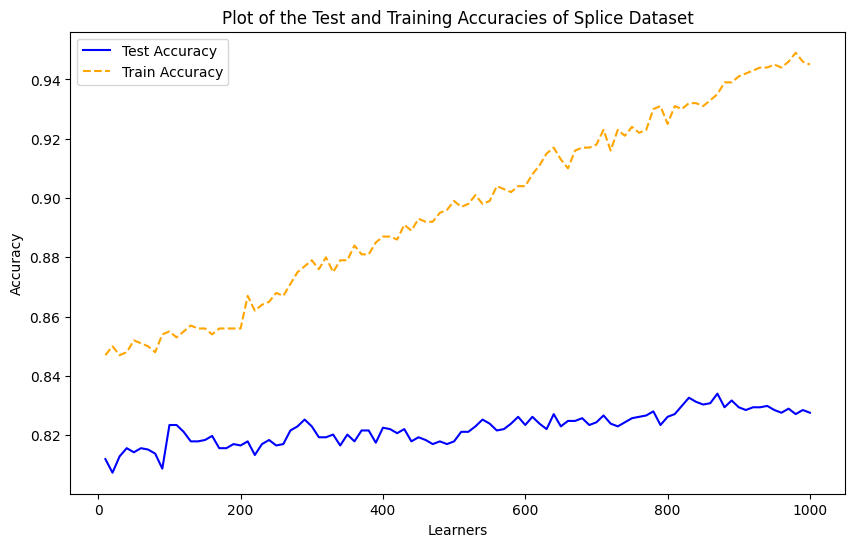

In [200]:
#-------------------------------------------
# Plot the accuracies for the splice dataset
#-------------------------------------------

plot_graphs(
    'Plot of the Test and Training Accuracies of Splice Dataset',
    testacc={ 'data': splice_test_accuracies, 'label': 'Test Accuracy', 'color': 'blue', 'linestyle': '-' },
    trainacc={ 'data': splice_train_accuracies, 'label': 'Train Accuracy', 'color': 'orange', 'linestyle': '--' }
)


Training time for splice dataset: 140.39549446105957 s
Test time for splice dataset: 0.034662485122680664


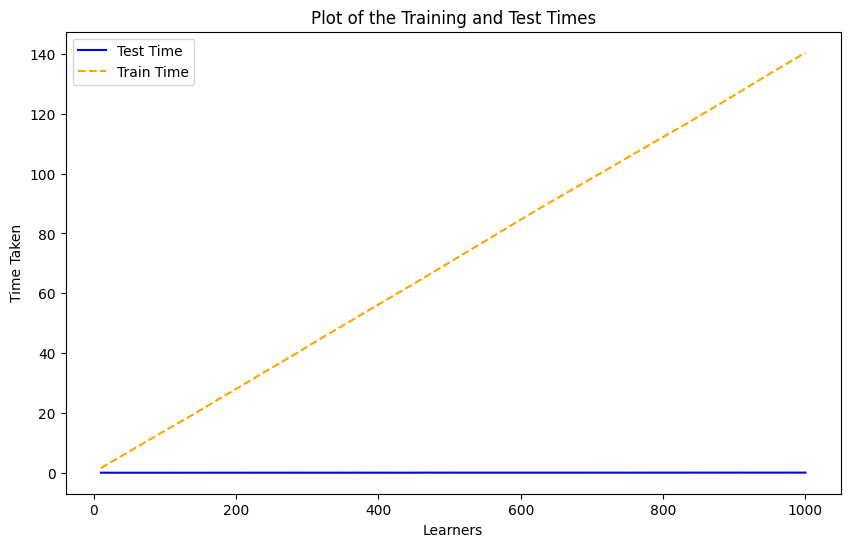

In [214]:
splice_cum_sum = np.cumsum(splice_train_speeds)
print(f'Training time for splice dataset: {splice_cum_sum[-1]} s')
print(f'Test time for splice dataset: {splice_test_speeds[-1]}')

plot_graphs(
    'Plot of the Training and Test Times',
    ylabel='Time Taken',
    testacc={ 'data': splice_test_speeds, 'label': 'Test Time', 'color': 'blue', 'linestyle': '-' },
    trainacc={ 'data': splice_cum_sum, 'label': 'Train Time', 'color': 'orange', 'linestyle': '--' }
)

### SVM Section

This section is where we use SVM to predict the class labels of both the banana and splice datasets.

We first try to look for the most optimal kernels and parameter settings for each dataset and then we print out their performance (accuracy and speed)

In [ ]:
# Define the SVM Model
svc = SVC()

# Define the parameter grid
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],  # Kernels to try
    'C': [0.1, 1, 10, 100],              # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient for 'rbf' and 'poly'
    'degree': [2, 3, 4]                  # Only relevant for 'poly' kernel
}


#---------------------------------------
# SVM for banana dataset
#---------------------------------------

# use gridsearchCV to find the best params
banana_grid_search = GridSearchCV(
    estimator=svc, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=1, 
    n_jobs=-1
)

# train the best model
banana_grid_search.fit(X_banana_train, y_banana_train)

# Print the best params and accuracy
print("Best Parameters:", banana_grid_search.best_params_)
print("Best Training Accuracy:", banana_grid_search.best_score_)

# Test the best model on the test set
best_model = banana_grid_search.best_estimator_
y_pred = best_model.predict(X_banana_test)
svm_banana_accuracy = accuracy(y_pred, y_banana_test)
print(f'Test Accuracy: {svm_banana_accuracy}')

# print out train and test time for the best model
banana_train_time = banana_grid_search.cv_results_['mean_fit_time'][banana_grid_search.best_index_]
banana_test_time = banana_grid_search.cv_results_['mean_score_time'][banana_grid_search.best_index_]
print(f'Banana SVM Train Time: {banana_train_time}')
print(f'Banana SVM Test Time: {banana_test_time}')

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Parameters: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best Training Accuracy: 0.875
Test Accuracy: 0.8920408163265307
Banana SVM Train Time: 0.004041624069213867
Banana SVM Test Time: 0.0011951923370361328


In [209]:
#---------------------------------------
# SVM for splice dataset
#---------------------------------------

# use gridsearchCV to find the best params
splice_grid_search = GridSearchCV(
    estimator=svc, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=1, 
    n_jobs=-1
)

# train the best model
splice_grid_search.fit(X_splice_train, y_splice_train)

# Print the best params and accuracy
print("Best Parameters:", splice_grid_search.best_params_)
print("Best Training Accuracy:", splice_grid_search.best_score_)

# Test the best model on the test set
best_model = splice_grid_search.best_estimator_
y_pred = best_model.predict(X_splice_test)
svm_splice_accuracy = accuracy(y_pred, y_splice_test)
print(f'Test Accuracy: {svm_splice_accuracy}')

# print out train and test time for the best model
splice_train_time = splice_grid_search.cv_results_['mean_fit_time'][splice_grid_search.best_index_]
splice_test_time = splice_grid_search.cv_results_['mean_score_time'][splice_grid_search.best_index_]
print(f'Splice SVM Train Time: {banana_train_time}')
print(f'Splice SVM Test Time: {banana_test_time}')

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Parameters: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Best Training Accuracy: 0.899
Test Accuracy: 0.8951724137931034
Splice SVM Train Time: 0.004041624069213867
Splice SVM Test Time: 0.0011951923370361328


### Comparison of SVM and Boosted Perceptron

First of all, the kernel and parameters that are best for the **banana dataset** are
##### Kernel Type
- **RBF (Radial Basis Function)**
##### Parameters
- **C**: 10
- **degree**: 2
- **gamma**: scale
------------------------------
The kernel and parameters that are best for the **splice dataset** are
##### Kernel Type
- **RBF (Radial Basis Function)**
##### Parameters
 - **C**: 10
- **degree**: 2
- **gamma**: auto
-------------------------------

Moving on, the performance comparison for SVM and Boosted Perceptron is as follows:
**For banana data**
| Classifier | Train Time| Test Time |       Accuracy     |
|:-----------|:------------:|------------:|--------|
| Adaboost   |   140.33 s    |      0.027 s |88.35%|
| SVM   |   0.004 s    |       0.0012 s|89.2%|

**For splice data**
| Classifier | Train Time| Test Time |       Accuracy     |
|:-----------|:------------:|------------:|--------|
| Adaboost   |   140.40 s    |      0.0347 s |82.76%|
| SVM   |   0.004 s    |       0.0012 s|89.52%|
